In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search
    !pip install -q gradio

In [8]:
from fastai.vision.all import *

In [9]:
from duckduckgo_search import ddg_images
from fastcore.all import *
import gradio as gr

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [10]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('uw husky football', max_images=1)
urls[0]

Searching for 'uw husky football'


'https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Washington_Huskies_logo.svg/1200px-Washington_Huskies_logo.svg.png'

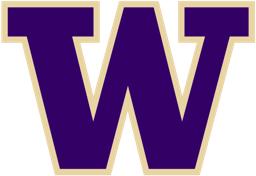

In [11]:
from fastdownload import download_url
dest = 'uw_husky.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [12]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('wsu cougar football', max_images=1)
urls[0]

Searching for 'wsu cougar football'


'https://ic-cdn.flipboard.com/seattletimes.com/aea083cefbda188545aa6520c76d080992acb0d2/_large.jpeg'

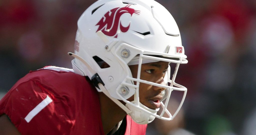

In [13]:
from fastdownload import download_url
dest = 'wsu_cougar.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [14]:
searches = 'uw husky football','wsu cougar football'
path = Path('husky_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} player'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} team'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'uw husky football photo'
Searching for 'uw husky football player'
Searching for 'uw husky football team'
Searching for 'wsu cougar football photo'
Searching for 'wsu cougar football player'
Searching for 'wsu cougar football team'


In [15]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

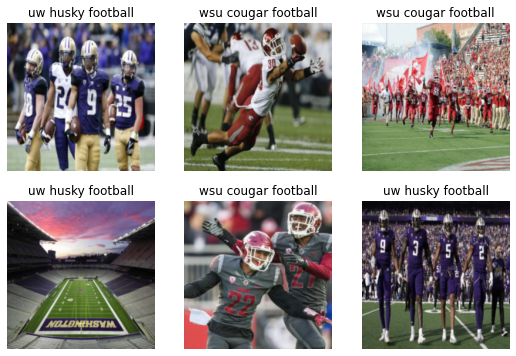

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.298854,0.722566,0.312500,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.644896,0.554852,0.218750,00:24
1,0.495381,0.425974,0.156250,00:28
2,0.349473,0.401087,0.093750,00:24


In [18]:
is_husky,_,probs = learn.predict(PILImage.create('uw_husky.jpg'))
print(f"This is a: {is_husky}.")
print(f"Probability it's a uw husky: {probs[0]:.4f}")

This is a: uw husky football.
Probability it's a uw husky: 0.8680


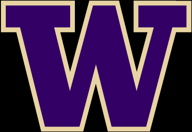

In [19]:
im = PILImage.create('uw_husky.jpg')
im.thumbnail((192, 192))
im

In [24]:
learn.export('model.pkl')

In [21]:
#/export
categories = ('UW Husky', 'WSU Cougar')

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [22]:
classify_image(im)

{'UW Husky': 0.8454393148422241, 'WSU Cougar': 0.15456067025661469}

In [23]:
#/export
image = gr.inputs.Image(shape = (192, 192))
label = gr.outputs.Label()
examples = ['uw_husky.jpg', 'wsu_cougar.jpg']

intf = gr.Interface(fn = classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline = True)

/opt/conda/lib/python3.7/site-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/opt/conda/lib/python3.7/site-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/opt/conda/lib/python3.7/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x7fdc4bd96190>, 'http://127.0.0.1:7860/', None)